In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf



In [10]:
# You only need to run this once, this is default commented out for this reason
# Creates cleaned_df.pkl in the data folder
#%run ./data/cleaning_script.py


In [2]:
df = pd.read_pickle('data/cleaned_df.pkl')

In [3]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing'],
      dtype='object')

In [4]:

df.iat[8748, 3] = 4
df.iat[15856, 3] = 3
df.sort_values('bedrooms', ascending=False)
#df['bedrooms_per_sf'] = df.bedrooms/df.sqft_living
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing'],
      dtype='object')

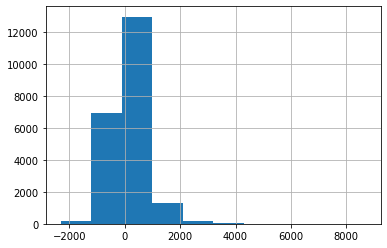

In [31]:
#np.log(df.sqft_living).hist()
df['log_sqft_living'] = np.log(df.sqft_living)
df['diff_lsf_neighbors'] = df.sqft_living - df.sqft_living15
df.diff_lsf_neighbors.hist()

In [54]:
mean_log_sqft_living = df.log_sqft_living.mean()
sigma_log_sqft_living = df.log_sqft_living.std()
df['log_normal_sf_living'] = (df.log_sqft_living - mean_log_sqft_living) / sigma_log_sqft_living

In [55]:
mean_sqft_living = df.sqft_living.mean()
sigma_sqft_living = df.sqft_living.std()
df['normal_sf_living'] = (df.sqft_living - mean_sqft_living) / sigma_sqft_living

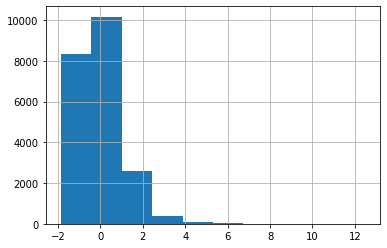

In [52]:
df.normal_sf_living.hist()

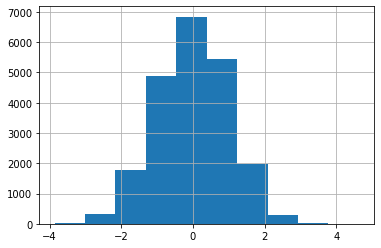

In [56]:
df.log_normal_sf_living.hist()

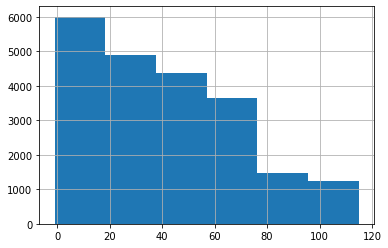

In [73]:
df.effective_age.hist(bins=6)

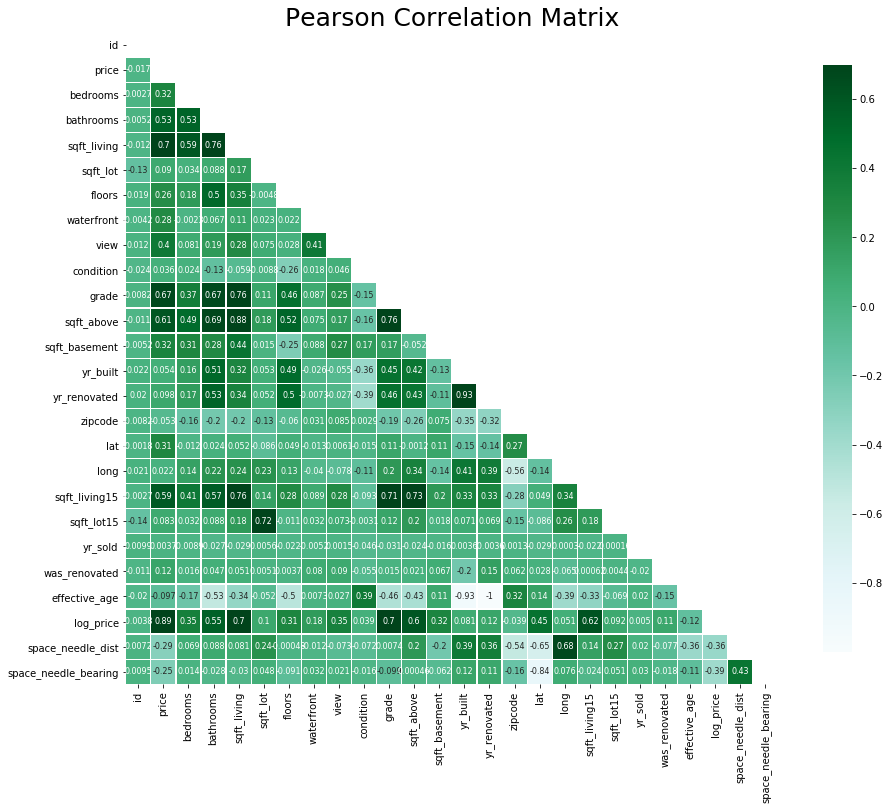

In [5]:
features = list(df.columns)

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


In [99]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=16)


In [100]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_lat_long_logprice = train_set[['lat', 'long', 'log_price']]

train_scaled = scaler.fit_transform(train_lat_long_logprice)
pd.DataFrame(train_scaled).describe()



,0,1,2
count,1.727700e+04,1.727700e+04,1.727700e+04
mean,-2.450371e-14,-1.110319e-14,1.147899e-15
std,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.901535e+00,-2.162501e+00,-3.394225e+00
25%,-6.489703e-01,-8.150584e-01,-7.025647e-01
50%,8.293319e-02,-1.200615e-01,-5.248630e-02
75%,8.536988e-01,6.316697e-01,6.280447e-01
max,1.572648e+00,6.376031e+00,5.362304e+00


Text(0, 0.5, 'Inertia')

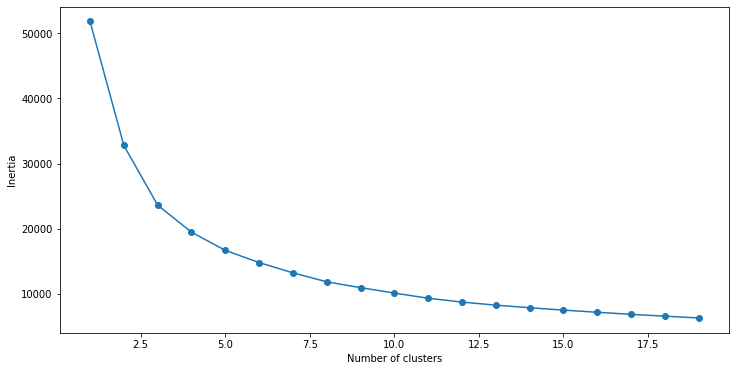

In [101]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(train_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [192]:
kmeans = KMeans(n_jobs = -1, n_clusters = 10, init='k-means++', random_state=16)
kmeans.fit(train_scaled)
train_pred = kmeans.predict(train_scaled)


train_frame = pd.DataFrame(train_scaled)
train_frame['cluster'] = train_pred
train_frame['cluster'].value_counts()

train_centers = kmeans.cluster_centers_
train_centers_frame = pd.DataFrame(scaler.inverse_transform(train_centers), columns=['klat', 'klong', 'log'])[['klat','klong']]
train_centers_frame.sort_values(by='klat', inplace=True)
train_centers_frame.reset_index(drop=True, inplace=True)
train_centers_frame


,klat,klong
0,47.333140,-122.282211
1,47.333148,-122.051304
2,47.459398,-122.166446
3,47.515731,-122.330990
4,47.545146,-121.844552
5,47.597499,-122.078391
6,47.618023,-122.242251
7,47.635279,-122.341731
8,47.704926,-122.128835
9,47.719319,-122.317582


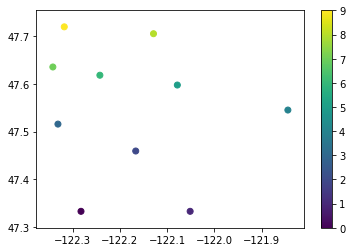

In [193]:
plt.scatter(train_centers_frame.klong, train_centers_frame.klat, c = train_centers_frame.index,
           label = train_centers_frame.index)
plt.colorbar()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


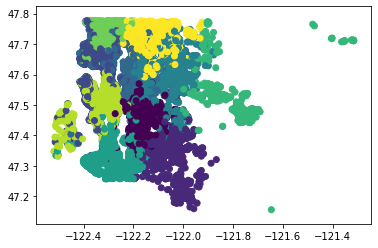

In [194]:
train_set['cluster'] = train_pred
plt.scatter(train_set.long, train_set.lat, c=train_set.cluster)

In [9]:
def distance_from(flat, flong, lat, long):
    """return 'as the crow flies' distance in miles from the 
    space needle, given latitude and longitude coordinates of a location"""
    # Convert lat/longitudes to radians
    def to_radians(latlong):
        return latlong / 57.29577951
    # lat/long of input
    loc_lat = to_radians(lat)
    loc_long = to_radians(long)
    c_lat = to_radians(flat)
    c_long = to_radians(flong)
    # distance in miles
    d = 3963.0 * np.arccos((np.sin(c_lat) * np.sin(loc_lat))\
                           + np.cos(c_lat) * np.cos(loc_lat)\
                           * np.cos(loc_long - c_long))
    return d

    
# Create a Function for computing the bearing relative from space needle
# of a given lat/long point
def bearing_from(flat, flong, lat, long):
    """return bearing theta in radians for given location's
    bearing relative to the space needle. Takes latitude and longitude
    of the location."""
    delta_fi = np.log(np.tan(flat / 2 + np.pi/4) / np.tan(lat / 2 + np.pi/4))
    delta_lon = abs(flong - long)
    bearing = np.arctan2(delta_lon, delta_fi)
    return bearing

In [191]:
drop_cols = train_set.columns[-9:]
train_set.drop(columns=drop_cols, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [190]:
train_set.columns[-9:]

Index(['cluster', 'dist_c0', 'bear_c0', 'dist_c1', 'bear_c1', 'dist_c2',
       'bear_c2', 'dist_c3', 'bear_c3'],
      dtype='object')

In [195]:
train_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,yr_sold,was_renovated,effective_age,log_price,space_needle_dist,space_needle_bearing,cluster
10728,2881700273,2014-08-19,385000.0,4,2.00,1820,7102,1.0,NaN,0.0,...,-122.324,1650,8184,2014,False,64.0,12.860999,8.670999,0.170848,7
7610,1823059106,2015-04-28,288250.0,3,1.75,2110,15400,1.0,0.0,0.0,...,-122.226,2110,9800,2015,False,52.0,12.571583,10.933743,2.446916,0
605,240000058,2015-04-08,469000.0,4,2.75,3550,13938,1.0,0.0,0.0,...,-122.283,2050,9000,2015,False,49.0,13.058358,13.872296,2.839314,0
10826,1232001040,2014-10-16,435000.0,3,1.00,1180,4219,1.0,0.0,0.0,...,-122.378,1630,4219,2014,False,75.0,12.983101,4.770139,0.357898,7
4360,4468400214,2014-10-10,318000.0,3,2.25,1250,1017,3.0,NaN,0.0,...,-122.333,1250,1017,2014,False,6.0,12.669807,6.230007,0.154919,7


In [196]:
for i in train_centers_frame.index:
    dist_col_name = f'dist_c{i}'
    bear_col_name = f'bear_c{i}'
    train_set[dist_col_name] = distance_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)
    train_set[bear_col_name] = bearing_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)

# train_set['dist_c0'] = distance_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], train_set.lat, train_set.long)
# train_set['bear_c0'] = bearing_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], train_set.lat, train_set.long)
# train_set['dist_c1'] = distance_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], train_set.lat, train_set.long)
# train_set['bear_c1'] = bearing_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], train_set.lat, train_set.long)
# train_set['dist_c2'] = distance_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], train_set.lat, train_set.long)
# train_set['bear_c2'] = bearing_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], train_set.lat, train_set.long)
# # train_set['dist_c3'] = distance_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], train_set.lat, train_set.long)
# # train_set['bear_c3'] = bearing_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], train_set.lat, train_set.long)
# # train_set['dist_c4'] = distance_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], train_set.lat, train_set.long)
# # train_set['bear_c4'] = bearing_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], train_set.lat, train_set.long)
# train_set.drop(columns=['dist_c3', 'dist_c4', 'bear_c3', 'bear_c4'], inplace=True)
train_set


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,dist_c5,bear_c5,dist_c6,bear_c6,dist_c7,bear_c7,dist_c8,bear_c8,dist_c9,bear_c9
10728,2881700273,2014-08-19,385000.0,4,2.00,1820,7102,1.0,NaN,0.0,...,15.314242,0.958114,9.553184,0.500517,7.613237,0.135801,9.488305,1.328537,1.780745,0.204633
7610,1823059106,2015-04-28,288250.0,3,1.75,2110,15400,1.0,0.0,0.0,...,10.337808,2.261401,9.156235,3.030105,11.646748,2.529519,15.799611,2.765963,16.687019,2.807322
605,240000058,2015-04-08,469000.0,4,2.75,3550,13938,1.0,0.0,0.0,...,15.288270,2.310223,13.485873,2.949752,14.800841,2.891051,20.655412,2.681417,20.421146,3.036653
10826,1232001040,2014-10-16,435000.0,3,1.00,1180,4219,1.0,0.0,0.0,...,15.264835,1.240451,7.910097,1.040713,3.937564,0.544753,11.668013,1.657572,3.605502,2.143734
4360,4468400214,2014-10-10,318000.0,3,2.25,1250,1017,3.0,NaN,0.0,...,14.183287,1.097547,7.632506,0.702532,5.177314,0.099460,9.508882,1.541612,0.969177,2.204983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17729,7214790110,2014-06-13,665000.0,4,2.50,2790,43091,2.0,NaN,0.0,...,12.339770,0.007607,13.277724,0.711346,15.588871,0.998635,5.409142,0.511363,11.722027,1.285335
581,7511800070,2014-08-21,264000.0,3,1.50,1820,10608,1.0,0.0,0.0,...,20.950179,2.455610,19.692093,2.933042,20.726268,3.030711,26.786503,2.726912,26.477210,3.114009
2169,1320069271,2014-06-12,342500.0,3,2.00,2080,11375,1.0,0.0,0.0,...,26.825126,2.932360,30.282392,2.611518,33.397283,2.476919,34.545127,2.889131,38.104425,2.603522
15598,8074200185,2014-08-25,370000.0,3,2.75,2120,7650,1.0,0.0,0.0,...,8.635572,2.429246,9.198601,2.707302,12.497884,2.339075,14.884495,2.939330,16.998055,2.644137


In [197]:
col_combos = [f'+ dist_c{i}*bear_c{i} ' for i in train_centers_frame.index]
formula = 'log_price ~ sqft_living ' + ''.join(col_combos)


model = smf.ols(formula=formula, data=train_set)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2571.
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:41:24   Log-Likelihood:                 1552.6
No. Observations:               17277   AIC:                            -3041.
Df Residuals:                   17245   BIC:                            -2793.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.9486      0.115    121.745      0.000      13.724      14.173
sqft_living         0.0003   2.02e-06    171.940      0.000       0.000       0.000
dist_c0            -0.0686      0.004    -17.189      0.000      -0.076      -0.061
bear_c0             0.0298      0.012      2.484      0.013       0.006       0.053
dist_c0:bear_c0     0.0244      0.002     10.964      0.000       0.020       0.029
dist_c1             0.0115      0.006      2.045      0.041       0.000       0.023
bear_c1             0.1114      0.016      7.053      0.000       0.080       0.142
dist_c1:bear_c1    -0.0130      0.003     -4.542      0.000      -0.019      -0.007
dist_c2            -0.0272      0.005     -5.239      0.000      -0.037      -0.017
bear_c2             0.0118      0.009      1.312      0.190      -0.006       0.029
dist_c2:bear_c2     0.0306      0.003     11.547      0.000       0.025       0.036
dist_c3             0.0319      0.008      4.226      0.000       0.017       0.047
bear_c3             0.1421      0.011     12.691      0.000       0.120       0.164
dist_c3:bear_c3     0.0274      0.004      7.269      0.000       0.020       0.035
dist_c4            -0.0231      0.008     -2.928      0.003      -0.038      -0.008
bear_c4             0.0275      0.023      1.189      0.234      -0.018       0.073
dist_c4:bear_c4     0.0277      0.004      7.574      0.000       0.021       0.035
dist_c5             0.0519      0.007      7.918      0.000       0.039       0.065
bear_c5             0.0660      0.012      5.554      0.000       0.043       0.089
dist_c5:bear_c5    -0.0091      0.003     -2.862      0.004      -0.015      -0.003
dist_c6            -0.1269      0.006    -22.036      0.000      -0.138      -0.116
bear_c6            -0.0226      0.015     -1.520      0.129      -0.052       0.007
dist_c6:bear_c6    -0.0240      0.003     -9.455      0.000      -0.029      -0.019
dist_c7             0.0023      0.007      0.319      0.750      -0.012       0.017
bear_c7            -0.1041      0.013     -7.809      0.000      -0.130      -0.078
dist_c7:bear_c7    -0.0128      0.004     -2.867      0.004      -0.022      -0.004
dist_c8             0.0298      0.005      5.704      0.000       0.020       0.040
bear_c8            -0.0951      0.012     -7.682      0.000      -0.119      -0.071
dist_c8:bear_c8    -0.0166      0.003     -6.350      0.000      -0.022      -0.011
dist_c9             0.1125      0.007     16.573      0.000       0.099       0.126
bear_c9             0.0051      0.009      0.553      0.580      -0.013       0.023
dist_c9:bear_c9    -0.0422      0.003    -12.429      0.000      -0.049      -0.036
==============================================================================
Omnibus:                     1430.818   Durbin-Watson:          

In [209]:
cols = list(train_set.columns[-20:])
cols.append('sqft_living')
cols

['dist_c0',
 'bear_c0',
 'dist_c1',
 'bear_c1',
 'dist_c2',
 'bear_c2',
 'dist_c3',
 'bear_c3',
 'dist_c4',
 'bear_c4',
 'dist_c5',
 'bear_c5',
 'dist_c6',
 'bear_c6',
 'dist_c7',
 'bear_c7',
 'dist_c8',
 'bear_c8',
 'dist_c9',
 'bear_c9',
 'sqft_living']

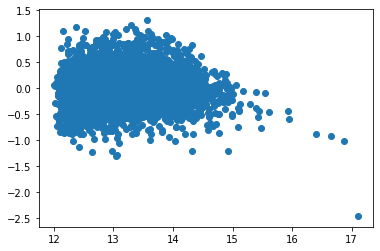

In [210]:
x_preds = train_set[cols]
y_actual = train_set['log_price']
model_predictions = fitted_model.predict(x_preds)
residuals = y_actual - model_predictions
plt.scatter(model_predictions, residuals)


In [287]:
outliers = list(model_predictions[model_predictions >15.5].index)
outliers

[7245, 4407, 1446, 1162, 12764, 9245, 8085, 7028]

In [283]:

living_8000 = train_set.sqft_living >= 8000


In [286]:
len(train_set) - len(train_set.loc[~ living_8000])

9

In [273]:
train_set.loc[train_set.index.isin(outliers), list(train_set.columns[2:-20])]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,yr_sold,was_renovated,effective_age,log_price,space_needle_dist,space_needle_bearing,cluster
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,3.0,4,13,...,-122.323,3940,8800,2014,True,27.0,15.856731,1.384537,1.187518,3
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,0.0,3,13,...,-122.233,3560,24345,2014,False,13.0,15.532906,5.452683,1.488643,3
1446,5350000.0,5,5.00,8000,23985,2.0,0.0,4.0,3,12,...,-122.220,4600,21750,2015,False,6.0,15.492607,6.030891,1.547033,3
1162,5110000.0,5,5.25,8010,45517,2.0,1.0,4.0,3,12,...,-122.211,3430,26788,2014,False,15.0,15.446710,7.525897,1.131737,3
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,4.0,3,12,...,-121.986,4850,217800,2014,False,15.0,14.639686,17.239234,1.422780,3
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,4.0,3,13,...,-122.240,4540,42730,2014,False,13.0,15.745582,5.141971,1.466826,3
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,4.0,3,12,...,-122.210,3270,10454,2014,True,5.0,15.356670,7.843395,2.042487,3
7028,3800000.0,5,5.50,7050,42840,1.0,0.0,2.0,4,13,...,-122.220,5070,20570,2014,False,36.0,15.150512,6.030301,1.549674,3


In [28]:
test_set['dist_c0'] = distance_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], test_set.lat, test_set.long)
test_set['bear_c0'] = bearing_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], test_set.lat, test_set.long)
test_set['dist_c1'] = distance_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], test_set.lat, test_set.long)
test_set['bear_c1'] = bearing_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], test_set.lat, test_set.long)
test_set['dist_c2'] = distance_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], test_set.lat, test_set.long)
test_set['bear_c2'] = bearing_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], test_set.lat, test_set.long)
test_set['dist_c3'] = distance_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], test_set.lat, test_set.long)
test_set['bear_c3'] = bearing_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], test_set.lat, test_set.long)
test_set['dist_c4'] = distance_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], test_set.lat, test_set.long)
test_set['bear_c4'] = bearing_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], test_set.lat, test_set.long)



test_x_preds = test_set[['sqft_living', 'dist_c0', 'bear_c0', 'bear_c1', 'dist_c2', 'bear_c2', 'dist_c3', 'bear_c3', 'dist_c4', 'bear_c4']]

test_preds = fitted_model.predict(test_x_preds)

log_price_mean = test_set.log_price.mean()
TSS = ((test_set.log_price - (log_price_mean))**2).sum()
RSS = ((test_set.log_price - test_preds)**2).sum()

R_sq = 1 - (RSS / TSS)

R_sq

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

0.809901189011705

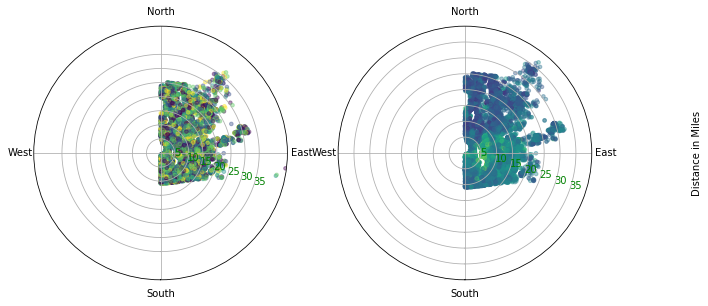

In [24]:
# df['cluster'] = pred

# df['log10_price'] = np.log10(df.price)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('seaborn-white')
r = train_set.space_needle_dist
theta = train_set.space_needle_bearing
area = train_set.log_price
colors = train_set.cluster


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, alpha=0.4 )
ax.set_theta_zero_location('W', offset=90)
ax.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
ax.set_xticklabels(['South','East', 'North', 'West'])
#ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
ax.set_rmax(45)
#ax.set_tickparams(axis='y', colors='red')
#ax.r_label_position('right')
ax.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
ax.set_ylabel('Distance in Miles', labelpad=100)
ax.yaxis.set_label_position('right')
#ax.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')




ax1 = fig.add_subplot(122, projection='polar')
c2 = ax1.scatter(theta, r, c=area, s=area, alpha=0.4)
ax1.set_theta_zero_location('W', offset=90)
ax1.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
ax1.set_xticklabels(['South','East', 'North', 'West'])
#ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
ax1.set_rmax(40)
#ax.set_tickparams(axis='y', colors='red')
#ax.r_label_position('right')
ax1.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
ax1.set_ylabel('Distance in Miles', labelpad=100)
ax1.yaxis.set_label_position('right')
#ax1.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')

# ax3 = fig.add_subplot(133, projection='polar')
# c3 = ax3.scatter(theta, r, c=colors2, s=area, alpha=0.4)
# ax3.set_theta_zero_location('W', offset=90)
# ax3.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
# ax3.set_xticklabels(['South','East', 'North', 'West'])
# #ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
# ax3.set_rmax(40)
# #ax.set_tickparams(axis='y', colors='red')
# #ax.r_label_position('right')
# ax3.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
# ax3.set_ylabel('Distance in Miles', labelpad=100)
# ax3.yaxis.set_label_position('right')
# #ax.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')



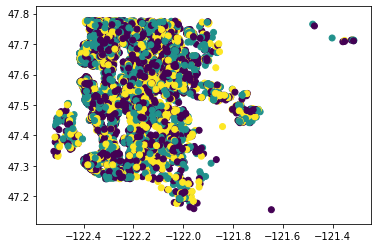

In [51]:
plt.scatter(train_set.long, train_set.lat, c=train_set.cluster)

In [104]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


lat_long_logprice = df[['lat', 'long', 'log_price']]
data_scaled = scaler.fit_transform(lat_long_logprice)


db = DBSCAN(eps=0.3, min_samples=10).fit(data_scaled)

labels = db.labels_

df['cluster_db'] = labels

df.head()




,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,space_needle_bearing,bedrooms_per_sf,log_sqft_living,diff_lsf_neighbors,normal_sf_living,log_normal_sf_living,split_level,cluster,log10_price,cluster_db
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,2.489966,0.002542,7.073270,-160,-0.980629,-1.125556,0.0,3,5.346157,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0.251870,0.001167,7.851661,880,0.533357,0.709446,0.0,0,5.730782,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.699198,0.002597,6.646391,-1950,-1.427201,-2.131893,0.0,0,5.255273,-1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,2.765356,0.002041,7.580700,600,-0.131054,0.070674,0.0,0,5.781037,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1.584611,0.001786,7.426549,-120,-0.436030,-0.292725,0.0,4,5.707570,0


In [108]:
df.cluster_db.value_counts()

 0    20862
-1      465
 1      198
 4       35
 3       21
 2       11
 5        5
Name: cluster_db, dtype: int64

In [149]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing', 'bedrooms_per_sf', 'log_sqft_living',
       'diff_lsf_neighbors', 'normal_sf_living', 'log_normal_sf_living',
       'cluster', 'log10_price', 'dist_c0', 'bear_c0', 'dist_c1', 'bear_c1',
       'dist_c2', 'bear_c2', 'dist_c3', 'bear_c3', 'dist_c4', 'bear_c4'],
      dtype='object')